In [1]:
from comet_ml import Experiment
import scanpy as sc
import scirpy as ir
import pandas as pd
import torch
import yaml
import numpy as np

In [2]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

In [3]:
%load_ext autoreload
%autoreload 2

# Load dataset

### BCC Dataset

In [4]:
bcc = sc.read_h5ad('../data/BCC_Yost_2018/bcc_tcr_and_gene.h5ad')
bcc

AnnData object with n_obs × n_vars = 53030 × 23309
    obs: 'patient', 'treatment', 'sort', 'cluster', 'UMAP1', 'UMAP2', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_cdr3', 'IR_VJ_2_cdr3', 'IR_VDJ_1_cdr3', 'IR_VDJ_2_cdr3', 'IR_VJ_1_cdr3_nt', 'IR_VJ_2_cdr3_nt', 'IR_VDJ_1_cdr3_nt', 'IR_VDJ_2_cdr3_nt', 'IR_VJ_1_expr', 'IR_VJ_2_expr', 'IR_VDJ_1_expr', 'IR_VDJ_2_expr', 'IR_VJ_1_expr_raw', 'IR_VJ_2_expr_raw', 'IR_VDJ_1_expr_raw', 'IR_VDJ_2_expr_raw', 'IR_VJ_1_v_gene', 'IR_VJ_2_v_gene', 'IR_VDJ_1_v_gene', 'IR_VDJ_2_v_gene', 'IR_VJ_1_d_gene', 'IR_VJ_2_d_gene', 'IR_VDJ_1_d_gene', 'IR_VDJ_2_d_gene', 'IR_VJ_1_j_gene', 'IR_VJ_2_j_gene', 'IR_VDJ_1_j_gene', 'IR_VDJ_2_j_gene', 'IR_VJ_1_c_gene', 'IR_VJ_2_c_gene', 'IR_VDJ_1_c_gene', 'IR_VDJ_2_c_gene', 'IR_VJ_1_junction_ins', 'IR_VJ_2_junction_ins', 'IR_VDJ_1_junction_ins', 'IR_VDJ_2_junction_ins', 'has_ir', 'multi_chain', 'patient_tcr', 'treatment_tcr', 'cluster_tcr', 'UMAP1_tcr', 'UMAP2_tcr'

In [5]:
sc.pp.filter_genes(bcc, min_cells=2000)
sc.pp.filter_cells(bcc, min_genes=2000)
bcc.shape

C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(14214, 9038)

In [6]:
# Filter samples without IR and multichain
bcc = bcc[bcc.obs['has_ir'] == 'True']
bcc = bcc[bcc.obs['multi_chain'] != 'True']
bcc.shape

(6275, 9038)

### Some Preprocessing to represent TCR sequence in a certain format
Here we use labels, one-hot is also possible

In [7]:
# Filter out cells without TCR-beta seq
bcc = bcc[bcc.obs['IR_VDJ_1_cdr3'] != 'None']

In [8]:
# Get maximum sequence length as pad value
pad = bcc.obs['IR_VDJ_1_cdr3'].str.len().max()
pad = int(pad)

In [9]:
# encode amino acids to unique id, '_' is pad character, '<' start and '>' end symbol
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '<': 21, '>': 22}

In [10]:
# Despite TypeError it still works, TypeError is ignored by pandas
aa_to_id_ = tcr.utils.aa_encoding(bcc, read_col='IR_VDJ_1_cdr3', ohe_col='one_hot', label_col='tcr_seq', length_col='seq_len', pad=pad, aa_to_id=aa_to_id, start_end_symbol=True)
bcc.obs[['IR_VDJ_1_cdr3', 'tcr_seq', 'one_hot', 'seq_len']]

Trying to set attribute `.obs` of view, copying.


,IR_VDJ_1_cdr3,tcr_seq,one_hot,seq_len
cell.id,,,,
bcc.su001.pre.tcell_AAAGTAGGTCTGCCAG,<CASSPRGQGADEAFF>,"[21, 2, 1, 16, 16, 13, 15, 6, 14, 6, 1, 3, 4, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17
bcc.su001.pre.tcell_AACCATGCACTTGGAT,<CASSPLGGFGNQPQHF>,"[21, 2, 1, 16, 16, 13, 10, 6, 6, 5, 6, 12, 14,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",18
bcc.su001.pre.tcell_AAGGCAGAGGATGCGT,<CATSRDPAGGQETQYF>,"[21, 2, 1, 17, 16, 15, 3, 13, 1, 6, 6, 14, 4, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",18
bcc.su001.pre.tcell_ACACCCTGTACAGCAG,<CSARDGARGDETQYF>,"[21, 2, 16, 1, 15, 3, 6, 1, 15, 6, 3, 4, 17, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17
bcc.su001.pre.tcell_ACAGCTAAGGTGGGTT,<CASGTSHYNEQFF>,"[21, 2, 1, 16, 6, 17, 16, 7, 20, 12, 4, 14, 5,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15
...,...,...,...,...
bcc.su012.post.tcell_TCGGGACAGTTGTCGT,<CASSREGAGTGELFF>,"[21, 2, 1, 16, 16, 15, 4, 6, 1, 6, 17, 6, 4, 1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",17
bcc.su012.post.tcell_TCTGAGATCTCTGAGA,<CATSRDRKDNEQFF>,"[21, 2, 1, 17, 16, 15, 3, 15, 9, 3, 12, 4, 14,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",16
bcc.su012.post.tcell_TTGACTTTCAGTTGAC,<CASSFRGLYEQYF>,"[21, 2, 1, 16, 16, 5, 15, 6, 10, 20, 4, 14, 20...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",15


# Initialize and train model

In [11]:
experiment_name = 'example'
with open(f'../config/{experiment_name}.yaml') as file:
     params = yaml.load(file)
params

<ipython-input-11-bc9bb2d2d4da>:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(file)


{'seq_model_arch': 'BiGRU',
 'seq_model_hyperparams': {'embedding_dim': 16,
  'hidden_size': 256,
  'num_layers': 2,
  'dropout': 0.2,
  'bidirectional': True},
 'scRNA_model_arch': 'MLP',
 'scRNA_model_hyperparams': {'gene_hidden': [1024, 512],
  'activation': 'relu',
  'output_activation': 'linear',
  'dropout': 0.2,
  'batch_norm': True},
 'hdim': 128,
 'activation': 'relu',
 'dropout': 0.2,
 'batch_norm': True,
 'shared_hidden': [64],
 'zdim': 16,
 'lr': 0.0003,
 'batch_size': 256,
 'losses': ['MSE', 'CE'],
 'loss_weights': [0.1, 1.0, 0.0]}

In [12]:
experiment = Experiment(api_key='GIybZgliX1y4MON2NsbnRoxnA', workspace='tcr', project_name='GRU')

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/tcr/gru/7bc12592634f45eaaea8b086e2a93dc4



In [13]:
experiment.log_parameters(params)
experiment.log_parameter('experiment_name', experiment_name)

In [40]:
model = tcr.models.joint_model.JointModel(
    adatas=[bcc],  # adatas containing gene expression and TCR-seq
    names=['bcc'],
    aa_to_id = aa_to_id,  # dict {aa_char: id}
    seq_model_arch=params['seq_model_arch'],  # seq model architecture
    seq_model_hyperparams=params['seq_model_hyperparams'],  # dict of seq model hyperparameters
    scRNA_model_arch=params['scRNA_model_arch'],
    scRNA_model_hyperparams=params['scRNA_model_hyperparams'],
    zdim=params['zdim'],  # zdim
    hdim=params['hdim'],  # hidden dimension of scRNA and seq encoders
    activation=params['activation'],  # activation function of autoencoder hidden layers
    dropout=params['dropout'],
    batch_norm=params['batch_norm'],
    shared_hidden=params['shared_hidden'],  # hidden layers of shared encoder / decoder
    gene_layers=[],  # [] or list of str for layer keys of each dataset
    seq_keys=[]  # [] or list of str for seq keys of each dataset
)

In [31]:
# print model architecture
model.model

JointModelTorch(
  (seq_encoder): BiGRUEncoder(
    (embedding): Embedding(23, 16, padding_idx=0)
    (gru): GRU(16, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (output_layer): Linear(in_features=1024, out_features=128, bias=True)
  )
  (seq_decoder): BiGRUDecoder(
    (embedding): Embedding(23, 16, padding_idx=0)
    (hidden_state_layer): Linear(in_features=256, out_features=512, bias=True)
    (gru): GRU(16, 256, num_layers=2, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=256, out_features=23, bias=True)
  )
  (gene_encoder): MLP(
    (network): Sequential(
      (0): Sequential(
        (0): Linear(in_features=9038, out_features=1024, bias=False)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Linear(in_features=1024, out_features=512, bias=False)
        (1): BatchN

In [34]:
model.train(
    experiment_name=experiment_name,
    n_iters=None,
    n_epochs=5000,
    batch_size=params['batch_size'],
    lr=params['lr'],
    losses=params['losses'],  # list of losses for each modality: losses[0] := scRNA, losses[1] := TCR
    loss_weights=params['loss_weights'],  # [] or list of floats storing weighting of loss in order [scRNA, TCR, KLD]
    val_split=0.1,
    metadata=[],
    validate_every=20,
    print_every=20,
    num_workers=1,
    verbose=1,  # 0: only tdqm progress bar, 1: val loss, 2: train and val loss
    continue_training=True,
    device=None,
    comet=experiment
)

Epoch:   0%|                                                                                  | 0/4920 [00:00<?, ?it/s]



Val Loss: 2.4682235717773438
Val scRNA Loss: 0.9915926456451416
Val TCR Loss: 1.4766310453414917
Val KLD Loss: 0.0


Epoch:   0%|▎                                                                      | 21/4920 [01:52<8:08:24,  5.98s/it]



Val Loss: 2.4872887134552
Val scRNA Loss: 0.9823639392852783
Val TCR Loss: 1.5049247741699219
Val KLD Loss: 0.0


Epoch:   1%|▌                                                                      | 40/4920 [03:23<6:27:15,  4.76s/it]



Val Loss: 2.4046239852905273
Val scRNA Loss: 0.926689863204956
Val TCR Loss: 1.4779342412948608
Val KLD Loss: 0.0


Epoch:   1%|▊                                                                      | 60/4920 [05:03<6:27:52,  4.79s/it]



Val Loss: 2.360163927078247
Val scRNA Loss: 0.9488758444786072
Val TCR Loss: 1.4112881422042847
Val KLD Loss: 0.0


Epoch:   2%|█▏                                                                     | 81/4920 [06:51<7:53:49,  5.88s/it]



Val Loss: 2.48606276512146
Val scRNA Loss: 0.9774875640869141
Val TCR Loss: 1.508575201034546
Val KLD Loss: 0.0


Epoch:   2%|█▍                                                                     | 96/4920 [08:05<6:46:50,  5.06s/it]


KeyboardInterrupt: 

In [35]:
model.history

,epoch,loss,scRNA_loss,TCR_loss,KLD_loss
0,0,6.895936,4.436349,2.459587,0.0
1,20,3.346538,1.462543,1.883995,0.0
2,40,3.088514,1.203294,1.885220,0.0
3,60,2.819556,1.021070,1.798485,0.0
4,80,2.468224,0.991593,1.476631,0.0
5,100,2.487289,0.982364,1.504925,0.0
6,120,2.404624,0.926690,1.477934,0.0
7,140,2.360164,0.948876,1.411288,0.0
8,160,2.486063,0.977488,1.508575,0.0


In [39]:
model.train_history

,epoch,loss,scRNA_loss,TCR_loss,KLD_loss
0,0,10.697208,7.934582,2.762627,0.0
1,20,6.603712,4.714456,1.889256,0.0
2,40,6.438000,4.554487,1.883513,0.0
3,60,6.107460,4.287799,1.819662,0.0
4,80,5.819302,4.284187,1.535115,0.0
5,80,5.797165,4.270206,1.526959,0.0
6,100,5.643436,4.151219,1.492216,0.0
7,120,5.504408,4.046258,1.458150,0.0
8,140,5.348752,3.899818,1.448934,0.0
9,160,5.187761,3.750809,1.436951,0.0


ValueError: x and y must have same first dimension, but have shapes (9,) and (10,)

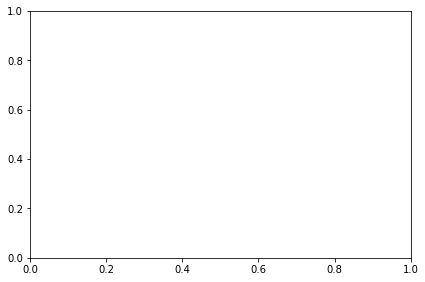

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['epoch'], model.train_history['loss'], '.-', label='Train loss');
plt.plot(model.history['epoch'], model.history['loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['epoch'], model.train_history['scRNA_loss'], '.-', label='Train scRNA loss');
plt.plot(model.history['epoch'], model.history['scRNA_loss'], '.-', label='Val scRNA loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['epoch'], model.train_history['TCR_loss'], '.-', label='Train TCR loss');
plt.plot(model.history['epoch'], model.history['TCR_loss'], '.-', label='Val TCR loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['epoch'], model.train_history['KLD_loss'], '.-', label='Train KLD loss');
plt.plot(model.history['epoch'], model.history['KLD_loss'], '.-', label='Val KLD loss');
plt.xlabel('#Iterations');
plt.legend();


# Predict

In [ ]:
z = model.get_latent(
    adatas=[bcc],
    names=['bcc'],
    batch_size=256,
    num_workers=0,
    gene_layers=[],
    seq_keys=[],
    metadata=['patient', 'cluster', 'treatment', 'sort']
)

In [ ]:
z

In [ ]:
sc.pp.neighbors(z)
sc.tl.umap(z)

In [ ]:
ax = sc.pl.umap(z, color=['patient', 'cluster', 'treatment', 'sort'], return_fig=True)
experiment.log_figure(figure_name='last_model', figure=ax)

In [ ]:
model.load(f'../saved_models/{experiment_name}_best_model.pt')

In [ ]:
z = model.get_latent(
    adatas=[bcc],
    names=['bcc'],
    batch_size=256,
    num_workers=0,
    gene_layers=[],
    seq_keys=[],
    metadata=['patient', 'cluster', 'treatment', 'sort']
)

In [ ]:
sc.pp.neighbors(z)
sc.tl.umap(z)

In [ ]:
ax = sc.pl.umap(z, color=['patient', 'cluster', 'treatment', 'sort'], return_fig=True)
experiment.log_figure(figure_name='best_model', figure=ax)